In [1]:
import pandas as pd
import numpy as np
from plotnine import *

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## 디렉토리지정

import os
file_directory = "/home/jovyan/work/Instacart/data"

os.chdir(file_directory)
os.getcwd()

'/home/jovyan/work/Instacart/data'

In [4]:
## 파일불러오기

aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [5]:
## 세팅

pd.set_option("max_rows", 100)
pd.set_option("max_columns", 100)

In [6]:
## products, departments, aisles 데이터를 Merge 함

products_merge = pd.merge(left = pd.merge(products, aisles, how ="left", on = "aisle_id"),
                                                            right = departments, 
                                                            how = "left", 
                                                            on="department_id")

In [7]:
category = products_merge[["product_id","product_name","aisle","department"]]

In [9]:
orders.head()
## order_id : 주문번호

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<ul>
<li>order_id : 주문번호</li> 
<li>user_id : 유저 고유번호</li>
<li>eval_set : order_id가 속한 데이터 지명</li>
<li>order_number : 주문한 상품 수</li>
<li>order_dow : 주문한 요일</li>
<li>order_hour_of_day : 주문한 시각(시간 별)</li>
<li>days_since_prior_order : 전 주문으로부터 지난 날짜</li>
</ul>

In [10]:
order_products_prior.columns == order_products_train.columns

array([ True,  True,  True,  True], dtype=bool)

In [11]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


<ul>
    <li>order_id : 주문번호</li>
    <li>product_id : 상품번호</li>
    <li>add_to_cart_order : 장바구니에 담기는 순서</li>
    <li>reordered : 해당 상품이 재주문된 상품인지</li>
</ul>

In [12]:
## orders를 eval_set을 기준으로 prior, train, test 3개의 데이터셋으로 나눔

prior = orders[lambda x :x["eval_set"]=="prior"].reset_index()
train = orders[lambda x :x["eval_set"]=="train"].reset_index()
test = orders[lambda x :x["eval_set"]=="test"].reset_index()

del prior["index"]
del train["index"]
del test["index"]

In [15]:
## orders를 각각 order_products_prior, order_products_train, sample_submission 과 Merge 함


order_prior = pd.merge(left = pd.merge(left = order_products_prior, right = prior, how = "left", on = "order_id"),
                                                   right=category,
                                                   how="left",
                                                   on="product_id")

order_train = pd.merge(left = pd.merge(left = order_products_train, right = train, how = "left", on = "order_id"),
                                                    right=category,
                                                  how="left",
                                                  on="product_id")

order_test = pd.merge(left = sample_submission, right = test, how = "left", on = "order_id")

In [16]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,baking ingredients,pantry


In [ ]:
## order_id는 예측에 무관함(데이터간 겹치는 order_id가 없으므로 order_id는 예측에 쓰이지 않는 것이 타당함)

test_id = set(order_test["order_id"])
train_id = set(order_train["order_id"])
prior_id = set(order_prior["order_id"])


print(test_id & train_id)
print(test_id & prior_id)
print(train_id & prior_id)

In [21]:
order_prior = order_prior[["user_id","order_id",
                                                       "product_id","product_name","aisle","department",
                                                        "add_to_cart_order","reordered",
                                                       "order_number","order_dow","order_hour_of_day",
                                                       "days_since_prior_order","eval_set"]].sort_values(["user_id", "order_id"]).reset_index()
    
order_train = order_train[["user_id","order_id",
                                                           "product_id","product_name","aisle","department",
                                                           "add_to_cart_order","reordered",
                                                           "order_number","order_dow","order_hour_of_day",
                                                           "days_since_prior_order","eval_set"]].sort_values(["user_id", "order_id"]).reset_index()

In [22]:
del order_prior["index"]
del order_train["index"]

In [23]:
order_prior.head()

,user_id,order_id,product_id,product_name,aisle,department,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,1,431534,196,Soda,soft drinks,beverages,1,1,5,4,15,28.0,prior
1,1,431534,12427,Original Beef Jerky,popcorn jerky,snacks,2,1,5,4,15,28.0,prior
2,1,431534,10258,Pistachios,nuts seeds dried fruit,snacks,3,1,5,4,15,28.0,prior
3,1,431534,25133,Organic String Cheese,packaged cheese,dairy eggs,4,1,5,4,15,28.0,prior
4,1,431534,10326,Organic Fuji Apples,fresh fruits,produce,5,0,5,4,15,28.0,prior


-----

In [25]:
order_test.head()

,order_id,products,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,17,39276 29259,36855,test,5,6,15,1.0
1,34,39276 29259,35220,test,20,3,11,8.0
2,137,39276 29259,187107,test,9,2,19,30.0
3,182,39276 29259,115892,test,28,0,11,8.0
4,257,39276 29259,35581,test,9,6,23,5.0


## 1. order_number : 주문수 별

In [52]:
order_prior.head()

,user_id,order_id,product_id,product_name,aisle,department,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,1,431534,196,Soda,soft drinks,beverages,1,1,5,4,15,28.0,prior
1,1,431534,12427,Original Beef Jerky,popcorn jerky,snacks,2,1,5,4,15,28.0,prior
2,1,431534,10258,Pistachios,nuts seeds dried fruit,snacks,3,1,5,4,15,28.0,prior
3,1,431534,25133,Organic String Cheese,packaged cheese,dairy eggs,4,1,5,4,15,28.0,prior
4,1,431534,10326,Organic Fuji Apples,fresh fruits,produce,5,0,5,4,15,28.0,prior


In [55]:
order_number_prior = order_prior[["eval_set","order_number","reordered"]].reset_index()
order_number_train = order_train[["eval_set","order_number","reordered"]].reset_index()

order_number = pd.concat([order_number_prior, order_number_train]).reset_index()

del order_number["level_0"]
del order_number["index"]

In [56]:
order_number.head()

,eval_set,order_number,reordered
0,prior,5,1
1,prior,5,1
2,prior,5,1
3,prior,5,1
4,prior,5,0


In [66]:
order_number_pct = order_number.groupby(["order_number"])["reordered"].agg(["sum","size"]).assign(pct = lambda x : x["sum"]/x["size"]).reset_index()

In [68]:
order_number_pct.head()

,order_number,sum,size,pct
0,1,0,2078068,0.000000
1,2,557885,2048332,0.272361
2,3,792161,2050731,0.386282
3,4,894580,1970180,0.454060
4,5,881757,1751959,0.503298


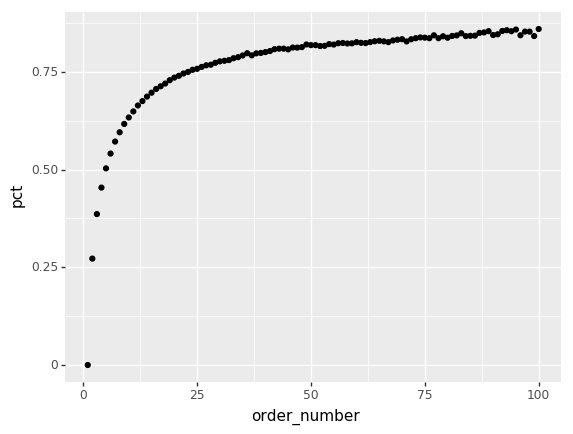

<ggplot: (8761405698210)>

In [69]:
(
    ggplot(order_number_pct, aes("order_number","pct"))
    +geom_point()
)

주문 수량이 많을수록 재주문률이 log함수 모양으로 올라간다 --> 왜지?

## 2.order_dow: 주문 요일 및 주문시각

In [72]:
order_dow_prior = order_prior[["eval_set","order_dow","reordered"]]
order_dow_train = order_train[["eval_set","order_dow", "reordered"]]

order_dow = pd.concat([order_dow_prior, order_dow_train]).reset_index()
del order_dow["index"]

In [79]:
order_dow_pct = order_dow.groupby(["order_dow"])["reordered"].agg(["sum","size"]).assign(pct = lambda x: x["sum"]/x["size"]).reset_index()

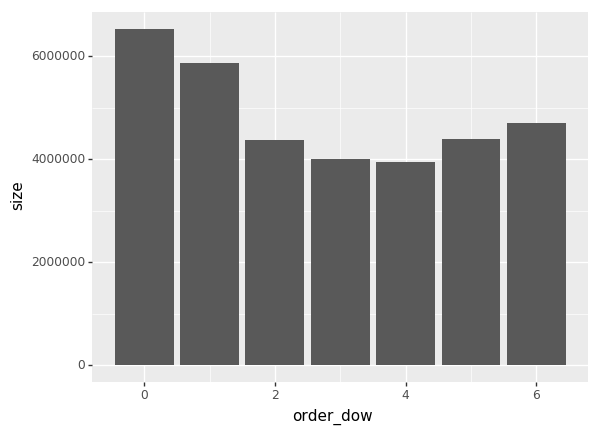

<ggplot: (8761378414863)>

In [100]:
(
    ggplot(order_dow_pct, aes("order_dow","size"))
    +geom_bar(stat="identity")

)

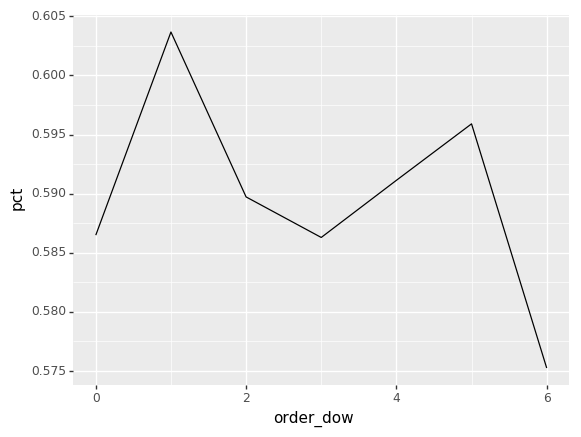

<ggplot: (8762126077935)>

In [98]:
(
    ggplot(order_dow_pct, aes("order_dow","pct"))
    +geom_freqpoly(stat="identity")

)

주문요일과 재주문률은 관계가 없어보임

## 3.order_hour_of_day: 주문시각

In [102]:
order_hour_prior = order_prior[["eval_set","order_hour_of_day","reordered"]]
order_hour_train = order_train[["eval_set","order_hour_of_day", "reordered"]]

order_hour = pd.concat([order_hour_prior, order_hour_train]).reset_index()
del order_hour["index"]

In [103]:
order_hour_pct = order_hour.groupby(["order_hour_of_day"])["reordered"].agg(["sum","size"]).assign(pct = lambda x: x["sum"]/x["size"]).reset_index()

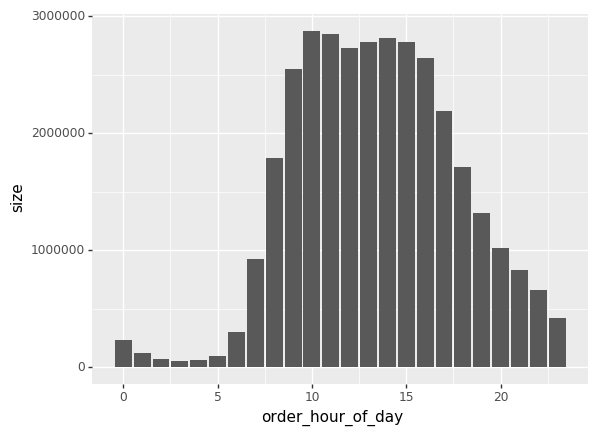

<ggplot: (-9223363274657358406)>

In [104]:
(
    ggplot(order_hour_pct, aes("order_hour_of_day","size"))
    +geom_bar(stat="identity")

)

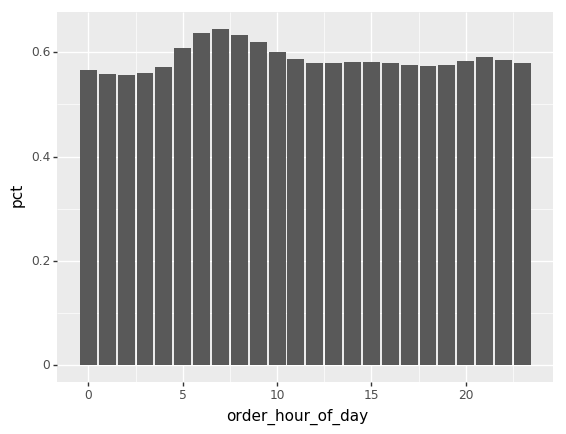

<ggplot: (8762197760860)>

In [105]:
(
    ggplot(order_hour_pct, aes("order_hour_of_day","pct"))
    +geom_bar(stat="identity")

)

주문 수 자체는 낮시간대에 몰리는 반면, 시간대별 재주문률은 차이가 없음

## 4. days_since_prior_order : 이전 주문 이후 며칠 뒤에 주문이 이루어지는가? 

In [106]:
order_test.head()

,order_id,products,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,17,39276 29259,36855,test,5,6,15,1.0
1,34,39276 29259,35220,test,20,3,11,8.0
2,137,39276 29259,187107,test,9,2,19,30.0
3,182,39276 29259,115892,test,28,0,11,8.0
4,257,39276 29259,35581,test,9,6,23,5.0


In [111]:
days_since_prior_order_prior = order_prior[["eval_set","days_since_prior_order","reordered"]]
days_since_prior_order_train = order_train[["eval_set","days_since_prior_order", "reordered"]]

days_since = pd.concat([days_since_prior_order_prior, days_since_prior_order_train]).reset_index()
del days_since["index"]

In [112]:
days_since_pct = days_since.groupby(["days_since_prior_order"])["reordered"].agg(["sum","size"]).assign(pct = lambda x: x["sum"]/x["size"]).reset_index()

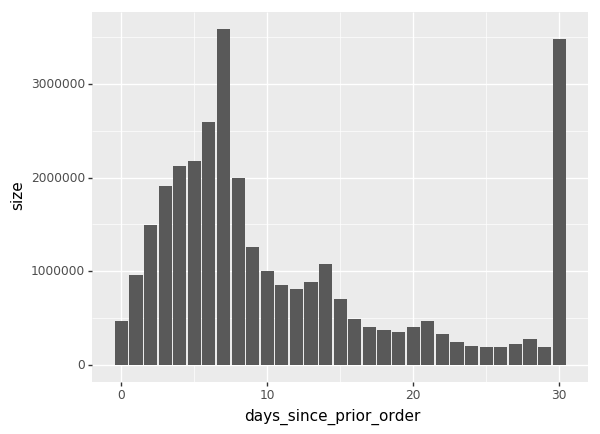

<ggplot: (-9223363274655974926)>

In [114]:
(
    ggplot(days_since_pct, aes("days_since_prior_order","size"))
    +geom_bar(stat="identity")

)

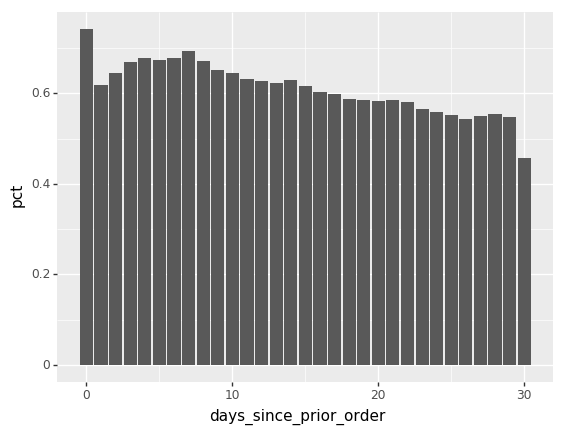

<ggplot: (-9223363275472612990)>

In [116]:
(
    ggplot(days_since_pct, aes("days_since_prior_order","pct"))
    +geom_bar(stat="identity")

)

주간 배송 및 월간 배송의 존재 및 
+ 이전배송이 몇번 이루어졌는지에 대한 컬럼 추가 필요 가능성